In [90]:

import heat_exchanger
from constants import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams["figure.figsize"] = (10, 6)

In [91]:

# read GA3_previous_desgins.csv

df = pd.read_csv('GA3_previous_designs.csv')

# remove weird group C designs
df = df[~((df["year"] == 2022) & (df["group"] == "Group-C"))] # remove group C 2022
df = df[~((df["year"] == 2023) & (df["group"] == "Group-C"))] # remove group C 2023

#df

In [92]:

HX = heat_exchanger.build_heat_exchanger([2],[2], 0.31, Side.OPPOSITE, Pattern.SQUARE)
HX.set_conditions([20, 60])


In [93]:
mdot_colds = np.zeros(len(df))
mdot_hots = np.zeros(len(df))
Qdots = np.zeros(len(df))
effs = np.zeros(len(df))

hot_passes = np.zeros(len(df))
cold_passes = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    hot_passes[i] = len(tubes)
    cold_passes[i] = len(baffles)

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE
    
    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

    if not result:
        continue

    Qdots[i] = HX.Qdot
    effs[i] = HX.effectiveness
    mdot_colds[i] = HX.mdot[0]
    mdot_hots[i] = HX.mdot[1]



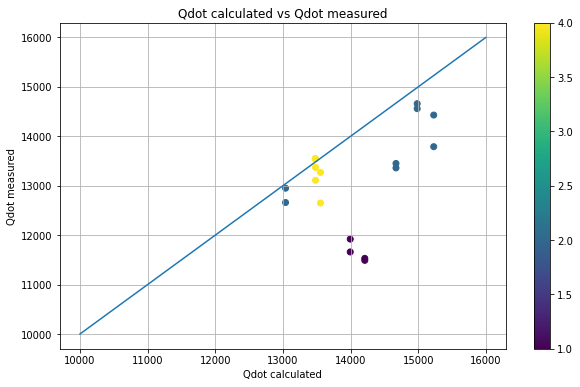

In [94]:
# plot Qdot calculated vs Qdot measured

lin = np.linspace(1e4, 1.6e4, 100)

plt.figure()
plt.scatter(Qdots, 1e3*df["Qcorr"], c=hot_passes)
plt.plot(lin, lin)
# colorbar
plt.colorbar()

plt.xlabel("Qdot calculated")
plt.ylabel("Qdot measured")
plt.title("Qdot calculated vs Qdot measured")
plt.grid()

# Doesnt look terrible!

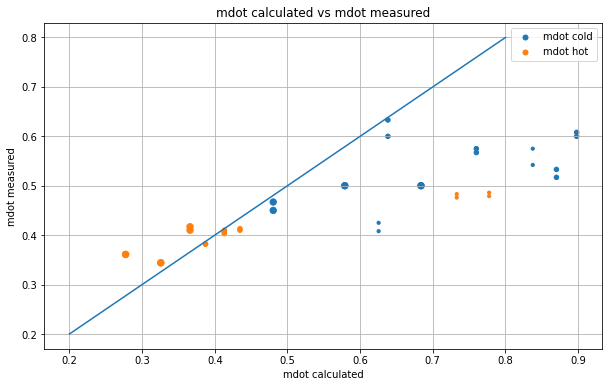

In [95]:
# plot mdot cold and mdot hot
lin = np.linspace(0.2, 0.8, 100)

plt.figure()
plt.scatter(mdot_colds, df["Flowrate1"], s=10 * hot_passes, label="mdot cold")
plt.scatter(mdot_hots, df["Flowrate2"],  s=10 * hot_passes, label="mdot hot")
plt.plot(lin, lin)

plt.xlabel("mdot calculated")
plt.ylabel("mdot measured")
plt.title("mdot calculated vs mdot measured")
plt.grid()
plt.legend()

# looks terrible need to fix


# sanity check measured mass flow and mass flow calculated from compressor characteristic data


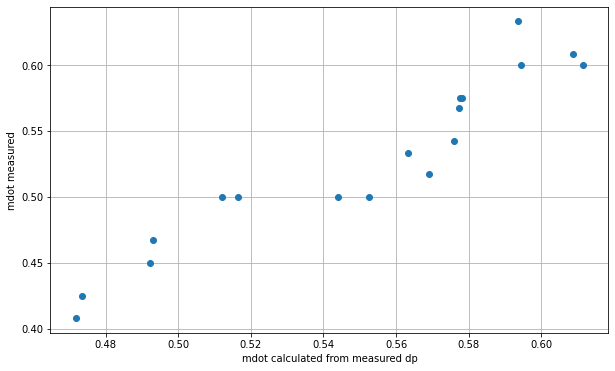

In [89]:
from heat_exchanger import cold_mass_flow_from_dp

mdot_cold_calc = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    mdot_cold_calc[i] = cold_mass_flow_from_dp(row[1][" DP_meas1"] * 1e5, row[1]["year"])

plt.figure()
plt.plot(mdot_cold_calc, df["Flowrate1"], 'o')
plt.xlabel("mdot calculated from measured dp")
plt.ylabel("mdot measured")
plt.grid()

plt.show()


# OK so the compressor characteristics are followed